In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score

# import kmeans1d
'''
kmeans1d

A Python library with an implementation of k-means clustering on 1D data, based on the algorithm in (Xiaolin 1991), as presented in section 2.2 of (Gronlund et al., 2017).

Globally optimal k-means clustering is NP-hard for multi-dimensional data. Lloyd's algorithm is a popular approach for finding a locally optimal solution. For 1-dimensional data, there are polynomial time algorithms. The algorithm implemented here is a O(kn + n log n) dynamic programming algorithm for finding the globally optimal k clusters for n 1D data points.

The code is written in C++, and wrapped with Python.
'''

# import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# shape (381109, 11)
# data_1 = pd.read_csv('datasets/d1.csv')
# data_1 = data_1.drop(['id'], axis=1)
data_1 = pd.read_csv('datasets/d1_bootstraped.csv')

data_2 = pd.read_csv('datasets/d2.csv')


In [3]:
data_1


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Female,46,1,28.0,1,1-2 Year,No,2630.0,124.0,255,0
1,Male,60,1,28.0,0,1-2 Year,Yes,40770.0,26.0,77,0
2,Male,59,1,48.0,0,> 2 Years,Yes,2630.0,124.0,30,0
3,Female,24,1,33.0,1,< 1 Year,No,29419.0,152.0,82,0
4,Male,22,1,18.0,1,< 1 Year,No,26714.0,152.0,156,0
...,...,...,...,...,...,...,...,...,...,...,...
93415,Female,43,1,28.0,0,1-2 Year,Yes,42013.0,125.0,199,1
93416,Female,30,1,8.0,0,< 1 Year,Yes,41314.0,124.0,128,1
93417,Male,40,1,13.0,0,1-2 Year,Yes,34503.0,26.0,163,1
93418,Male,58,1,28.0,0,> 2 Years,Yes,51016.0,26.0,164,1


In [4]:
data_1.nunique()


Gender                      2
Age                        66
Driving_License             2
Region_Code                53
Previously_Insured          2
Vehicle_Age                 3
Vehicle_Damage              2
Annual_Premium          32550
Policy_Sales_Channel      135
Vintage                   290
Response                    2
dtype: int64

1    53
0    47
Name: Response, dtype: int64

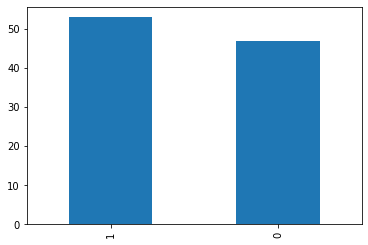

In [5]:
data_1 = data_1.sample(100)

data_1['Response'].value_counts().plot(kind='bar')
data_1['Response'].value_counts()


In [6]:
data_1.head()


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
63784,Male,31,1,21.0,0,1-2 Year,Yes,2630.0,26.0,126,1
40330,Female,22,1,47.0,1,< 1 Year,No,24579.0,152.0,49,0
35595,Female,41,1,41.0,0,1-2 Year,Yes,16984.0,29.0,51,0
9473,Female,23,1,27.0,0,< 1 Year,Yes,28898.0,152.0,195,0
8916,Male,52,1,30.0,0,> 2 Years,Yes,42341.0,26.0,120,0


In [7]:
top_n = 10
likely_dis = []

# check if attribute is continuous or discrete dataframe
for var in data_1.columns:
    # Find the ratio of number of unique values to the total number of unique values. Something like the following
    # if 1.*data_1[var].nunique()/data_1[var].count() > 0.5:

    # Check if the top n unique values account for more than a certain proportion of all values
    if 1.*data_1[var].value_counts(normalize=True).head(top_n).sum() < 0.5:
        likely_dis.append(var)

likely_dis


['Age', 'Annual_Premium', 'Vintage']

In [8]:
from itertools import combinations
columns_name = set(data_1.columns).difference(likely_dis)
columns_name.remove('Response')
combX = []
comb_max_depth = 3
for idx, _ in enumerate(columns_name):
    if comb_max_depth and comb_max_depth == idx:
        break
    combX.extend(list(combinations(columns_name, idx + 1)))

combX = sorted(combX, key=len)
combX


[('Vehicle_Age',),
 ('Driving_License',),
 ('Policy_Sales_Channel',),
 ('Region_Code',),
 ('Previously_Insured',),
 ('Gender',),
 ('Vehicle_Damage',),
 ('Vehicle_Age', 'Driving_License'),
 ('Vehicle_Age', 'Policy_Sales_Channel'),
 ('Vehicle_Age', 'Region_Code'),
 ('Vehicle_Age', 'Previously_Insured'),
 ('Vehicle_Age', 'Gender'),
 ('Vehicle_Age', 'Vehicle_Damage'),
 ('Driving_License', 'Policy_Sales_Channel'),
 ('Driving_License', 'Region_Code'),
 ('Driving_License', 'Previously_Insured'),
 ('Driving_License', 'Gender'),
 ('Driving_License', 'Vehicle_Damage'),
 ('Policy_Sales_Channel', 'Region_Code'),
 ('Policy_Sales_Channel', 'Previously_Insured'),
 ('Policy_Sales_Channel', 'Gender'),
 ('Policy_Sales_Channel', 'Vehicle_Damage'),
 ('Region_Code', 'Previously_Insured'),
 ('Region_Code', 'Gender'),
 ('Region_Code', 'Vehicle_Damage'),
 ('Previously_Insured', 'Gender'),
 ('Previously_Insured', 'Vehicle_Damage'),
 ('Gender', 'Vehicle_Damage'),
 ('Vehicle_Age', 'Driving_License', 'Policy_Sale

In [9]:
# Scaleing is a process of transforming data into a stander values so we can get the best of it
#
# https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering
scaler = StandardScaler()
scaled_column_names = [x for x in likely_dis if x.lower() not in ['id']]
data_cluster = data_1[scaled_column_names].copy()
scaled_data = scaler.fit_transform(data_cluster)

data_scaled = data_1.copy()
data_scaled[scaled_column_names] = scaled_data
data_scaled

# [['Vintage','Annual_Premium']]
# scaler.inverse_transform([[0.748795	, 0.574539]])


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
63784,Male,-0.658776,1,21.0,0,1-2 Year,Yes,-1.949749,26.0,-0.231033,1
40330,Female,-1.285519,1,47.0,1,< 1 Year,No,-0.416367,152.0,-1.148965,0
35595,Female,0.037605,1,41.0,0,1-2 Year,Yes,-0.946962,29.0,-1.125123,0
9473,Female,-1.215881,1,27.0,0,< 1 Year,Yes,-0.114637,152.0,0.591530,0
8916,Male,0.803624,1,30.0,0,> 2 Years,Yes,0.824507,26.0,-0.302560,0
...,...,...,...,...,...,...,...,...,...,...,...
28432,Female,-1.355157,1,15.0,1,< 1 Year,No,0.427556,152.0,-1.280098,0
44592,Male,-1.285519,1,15.0,1,< 1 Year,No,-0.140276,152.0,1.414093,0
71905,Female,-1.146243,1,45.0,0,< 1 Year,Yes,-0.017949,26.0,0.424633,1
33409,Female,0.176881,1,9.0,1,1-2 Year,No,1.078173,124.0,0.734584,0


In [10]:
from scipy import stats
data_scaled = data_scaled[(
    np.abs(stats.zscore(data_scaled.Annual_Premium)) < 3)]
data_scaled


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
63784,Male,-0.658776,1,21.0,0,1-2 Year,Yes,-1.949749,26.0,-0.231033,1
40330,Female,-1.285519,1,47.0,1,< 1 Year,No,-0.416367,152.0,-1.148965,0
35595,Female,0.037605,1,41.0,0,1-2 Year,Yes,-0.946962,29.0,-1.125123,0
9473,Female,-1.215881,1,27.0,0,< 1 Year,Yes,-0.114637,152.0,0.591530,0
8916,Male,0.803624,1,30.0,0,> 2 Years,Yes,0.824507,26.0,-0.302560,0
...,...,...,...,...,...,...,...,...,...,...,...
28432,Female,-1.355157,1,15.0,1,< 1 Year,No,0.427556,152.0,-1.280098,0
44592,Male,-1.285519,1,15.0,1,< 1 Year,No,-0.140276,152.0,1.414093,0
71905,Female,-1.146243,1,45.0,0,< 1 Year,Yes,-0.017949,26.0,0.424633,1
33409,Female,0.176881,1,9.0,1,1-2 Year,No,1.078173,124.0,0.734584,0


In [11]:
le = LabelEncoder()
encoder_dict = dict()
data_endocded = data_scaled.copy()

for col in data_endocded:
    if col not in ['Annual_Premium', 'Vintage']:
        le = le.fit(data_endocded[col])
        data_endocded[col] = le.transform(data_endocded[col])
        encoder_dict[col] = le

np.save('encoder_dict.npy', encoder_dict)
# encoder_dict = np.load('encoder_dict.npy', allow_pickle=True).tolist()
data_endocded.to_csv('data_endocded.csv', index=False)
data_endocded = pd.read_csv('data_endocded.csv')
data_endocded.head()


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,11,1,11,0,0,1,-1.949749,2,-0.231033,1
1,0,2,1,25,1,1,0,-0.416367,9,-1.148965,0
2,0,20,1,22,0,0,1,-0.946962,3,-1.125123,0
3,0,3,1,14,0,1,1,-0.114637,9,0.591530,0
4,1,31,1,17,0,2,1,0.824507,2,-0.302560,0


In [12]:
class RST:
    def __init__(
        self,
        data: pd.DataFrame = None,
        continuous_columns: list = [],
        decision_column_name: str = 'class',
    ):

        # Primary variable of RST class
        self._data = data
        self.continuous_columns = continuous_columns
        self.decision_column_name = decision_column_name
        self.data = self._data[set(self._data.columns).difference(
            self.continuous_columns)]
        self.data_indiscernibility = {}
        self.unique_indiscernibility = []
        self.reduct_combination = []
        self.lower_approx = {}
        self.upper_approx = {}
        self.boundary_region = {}
        self.outside_region = {}
        self.U = self._list_to_set_conversion(self.data.index.values.tolist())

        # Config Variable
        self.target_unique = self.data[decision_column_name].unique()
        self.target_sets = self.get_indiscernibility([decision_column_name])[0]
        self.target_sets_dict = {self.target_unique[idx]: ele for idx, ele in enumerate(
            self.target_sets[decision_column_name])}

    def get_indiscernibility(self, combination: list = []):

        def indices(lst, item):
            return [i for i, x in enumerate(lst) if x == item]

        if self.decision_column_name not in combination:
            combination.append(self.decision_column_name)

        selected_columns = self.data[combination].to_dict('list')
        data = list(zip(*selected_columns.values()))

        # print(combination, list(indices(data, x) for x in set(data) if data.count(x) > 1))
        if list(indices(data, x) for x in set(data) if data.count(x) > 1) in self.unique_indiscernibility:
            self.reduct_combination.append(self._create_names(combination))
        else:
            self.unique_indiscernibility.append(
                list(indices(data, x) for x in set(data) if data.count(x) > 1))

            self.data_indiscernibility.update({
                self._create_names(combination): list(indices(data, x) for x in set(data) if data.count(x) > 1)
            })

        return [self.data_indiscernibility, self.reduct_combination]

    def set_main_variable(self, combination: list = []):
        combination.append(self.decision_column_name)
        _c_n = self._create_names(combination)  # combination name

        if _c_n not in self.data_indiscernibility:
            self.get_indiscernibility(combination)
        if _c_n in self.reduct_combination:
            return [{}, {}, {}, {}]

        combination_upper = {}
        combination_lower = {}

        for target, set in self.target_sets_dict.items():
            c = combination.copy()
            c.append(str(target))
            __c_n = self._create_names(c)

            self.lower_approx.update({__c_n: []})
            self.upper_approx.update({__c_n: []})
            self.boundary_region.update({__c_n: []})
            self.outside_region.update({__c_n: []})

            for IND in self.data_indiscernibility[_c_n]:
                if all(True if x in set else False for x in IND):
                    self.lower_approx[__c_n].extend(IND)

                if any(True if x in set else False for x in IND):
                    self.upper_approx[__c_n].extend(IND)

            combination_lower.update({__c_n: self.lower_approx[__c_n]})
            combination_upper.update({__c_n: self.upper_approx[__c_n]})

            upper = self._list_to_set_conversion(self.upper_approx[__c_n])
            lower = self._list_to_set_conversion(self.lower_approx[__c_n])

            # print(upper, lower)
            self.boundary_region[__c_n].extend(upper - lower)
            self.outside_region[__c_n].extend(self.U - upper)
            # print(self.boundary_region)

        return [
            combination_upper,
            combination_lower,
            self.boundary_region[__c_n],
            self.outside_region[__c_n]
        ]

    def get_dependency(self, combination: list = []):
        _, lower, _, _ = self.set_main_variable(combination)
        divider = sum([len(v) for v in lower.values()])
        dependency = divider / len(self.U)
        return [
            lower,
            dependency
        ]

    def _create_names(self, e) -> str:
        return '|'.join(e)

    def _list_to_set_conversion(self, l):
        se = set()
        for x in l:
            se.add(x)
        return se


In [13]:
rst = RST(data_endocded, continuous_columns=likely_dis,
          decision_column_name='Response')
# upper, lower, boundary, outside = rst.set_main_variable(combination=['Gender', 'Age'])
dep = {}
ind = []
for comb in combX:
    lower, dependency = rst.get_dependency(combination=list(comb))
    dep.update({comb: dependency})
    # print(len(ind))

    # print(set(ind))
    # if indiscernibility in dep.keys():
    #     dep[indiscernibility].append(comb)
    # else:
    #     dep.update({indiscernibility: [comb]})
# dep


C:\Users\ahmad\AppData\Local\Temp\ipykernel_4612\219874019.py:13: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  self.data = self._data[set(self._data.columns).difference(self.continuous_columns)]


In [22]:
%%time
silhouette_scores = 5
data = pd.read_csv('test.csv')
marker = {}


def get_lower_edge_value(indices, value):
    lower_value = {}
    if len(indices) > 1:
        same_value = data.loc[indices[::len(indices)-1]].Age.values.tolist()
        if value not in [0, silhouette_scores]:
            lower_same_value = data.Age.isin([same_value[0]])
            lower_temp = data[lower_same_value]
            lower_value.update({
                value: {
                    'idx': lower_temp.index.tolist(),
                    'value': lower_temp.values.tolist()[0][0],
                }
            })

    return lower_value


def get_upper_edge_value(indices, value):
    upper_value = {}
    if len(indices) > 1:
        same_value = data.loc[indices[::len(indices)-1]].Age.values.tolist()
        if value in [0, silhouette_scores]:
            upper_same_value = data.Age.isin([same_value[1]])
        else:
            upper_same_value = data.Age.isin([same_value[1]])

        upper_temp = data[upper_same_value]
        upper_value.update({
            value: {
                'idx': upper_temp.index.tolist(),
                'value': upper_temp.values.tolist()[0][0],
            }
        })

    return upper_value


def get_outer_edge_values(indices, value):
    out_value = {}
    if len(indices) == 1:
        same_value = data.loc[indices].Age.values.tolist()
        out_same_value = data.Age.isin(same_value)
        out_temp = data[out_same_value]
        out_value.update({
            value: {
                'idx': out_temp.index.tolist(),
                'value': out_temp.values.tolist()[0][0],
            }
        })

    return out_value

value = 0
while value < silhouette_scores:
    indices = data[data.Age_AFTER == value].index.tolist()
    lower_edge_value = get_lower_edge_value(indices, value)
    upper_edge_value = get_upper_edge_value(indices, value)
    outer_edge_value = get_outer_edge_values(indices, value)
    value += 1

print(lower_edge_value)
print('--------------------------------')
print(upper_edge_value)
print('--------------------------------')
print(outer_edge_value)


{4: {'idx': [14], 'value': 39}}
--------------------------------
{4: {'idx': [15, 16], 'value': 40}}
--------------------------------
{}
CPU times: total: 31.2 ms
Wall time: 9.94 ms


In [25]:
a = b = 5